In [12]:
%matplotlib inline

In [13]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

#クラスター
from sklearn import mixture

#深層学習
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

# クラスター分けしてOLS

### 1 CSVをpandasで取り込む。

In [14]:
df = pd.read_csv('bukken_data.csv')
df = df[:][df['pay'] < 300000]
df = df.reset_index(drop=True)

In [15]:
df.columns

Index(['apart_dummy', 'building_year', 'dk', 'fX', 'fY', 'floor', 'k', 'lk',
       'mansyon_dumy', 'new_dummy', 'pay', 'published_date', 'r', 'rc_dummy',
       'room_nums', 'sdk', 'sk', 'sldk', 'slk', 'south_direction_dummy',
       'square', 'teiki_syakuya_dummy', 'walk_minute_dummy'],
      dtype='object')

### 2 部屋面積と位置でクラスター分類を利用してからOLS

In [59]:
def cluster_OLS(n):
    dum1 = pd.DataFrame((df['pay'] < 100000)*1)
    dum1.columns = ['low']
    dum2 = pd.DataFrame((df['pay'] > 150000)*1)
    dum2.columns = ['high']
    dum = pd.concat((dum1, dum2), axis=1)
    
    df_with_dummy = pd.concat((df, dum), axis=1)
    
    cluster_array = np.array([df['square'], df['fX']*1000, df['fY']*1000])
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
    dum = pd.get_dummies(gmm.predict(cluster_array.T))
    dum_nam = ['d%s'%i for i in range(n)] 
    dum.columns = dum_nam
    
    df_with_dummy = pd.concat((df_with_dummy, dum), axis=1)

    vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
            'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 
            'room_nums', 'low', 'high']
    vars = vars + dum_nam[:-1]

    eq = fml_build(vars)

    y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')
    
    y_in = y[1:1000]
    X_in = X[1:1000]
    
    y_ex = y[1000:]
    X_ex = X[1000:]

    logy_in = np.log(y_in)

    model = sm.GLS(logy_in, X_in, intercept=True)
    results = model.fit()
    print(results.summary())
    
    return results, np.array(y_ex).reshape(len(y_ex)), np.array(X_ex)

In [60]:
n=50

results, y_ex, X_ex = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.865
Model:                            GLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     97.03
Date:                Fri, 25 Nov 2016   Prob (F-statistic):               0.00
Time:                        18:51:40   Log-Likelihood:                 646.31
No. Observations:                 999   AIC:                            -1167.
Df Residuals:                     936   BIC:                            -857.5
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.83

[ -2058.72822694 -12058.72822694   2025.9571949   -2058.72822694
   1778.59356576  -2974.0428051    9850.00174397   4957.38474505
  10161.81131176  -5646.95695557  -5646.95695557 -12646.95695557
  32134.46686969  59730.46910525   7326.92849608  67955.82667695
  36757.51873117   8461.72022571  49211.38057774   7783.15981049]


(array([   4.,   19.,   64.,  152.,  117.,   46.,   11.,    5.,    6.,    3.]),
 array([-51644.22437441, -38328.01669036, -25011.80900631, -11695.60132225,
          1620.6063618 ,  14936.81404585,  28253.0217299 ,  41569.22941395,
         54885.437098  ,  68201.64478206,  81517.85246611]),
 <a list of 10 Patch objects>)

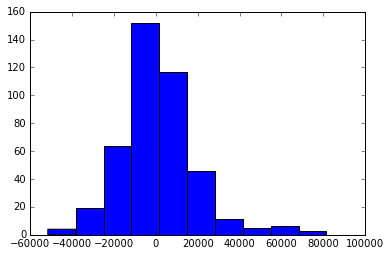

In [61]:
logy_pred = results.params.dot(X_ex.T)
y_pred = np.exp(logy_pred)
error = y_ex - y_pred
print(error[:20])
plt.hist(error)

In [62]:
print(sum(((error > -5000)*1)*((error < 5000)*1)))
print(sum(((error > -15000)*1)*((error < 15000)*1)))
print(sum(((error > -30000)*1)*((error < 30000)*1)))

130
299
393


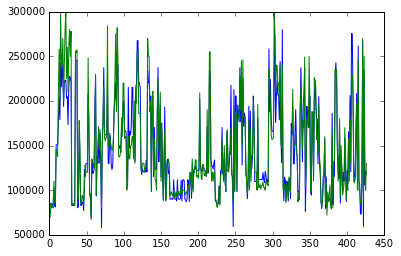

In [83]:
plt.plot(y_pred)
plt.plot(y_ex)

### 3 部屋面積と位置でクラスター分類を利用してからDeepLearning

In [25]:
class CAR(Chain):
    def __init__(self, unit1, unit2, unit3, col_num):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        super(CAR, self).__init__(
            l1 = L.Linear(col_num, unit1),
            l2 = L.Linear(self.unit1, self.unit1),
            l3 = L.Linear(self.unit1, self.unit2),
            l4 = L.Linear(self.unit2, self.unit3),
            l5 = L.Linear(self.unit3, self.unit3),
            l6 = L.Linear(self.unit3, 1),
        )
    
    def __call__(self, x, y):
        fv = self.fwd(x, y)
        loss = F.mean_squared_error(fv, y)
        return loss
    
    def fwd(self, x, y):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        h4 = F.sigmoid(self.l4(h3))
        h5 = F.sigmoid(self.l5(h4))
        h6 = self.l6(h5)
        return h6

In [42]:
def DL(df, n, bs = 200):
    dum1 = pd.DataFrame((df['pay'] < 100000)*1)
    dum1.columns = ['low']
    dum2 = pd.DataFrame((df['pay'] > 150000)*1)
    dum2.columns = ['high']
    dum = pd.concat((dum1, dum2), axis=1)
    
    df_with_dummy = pd.concat((df, dum), axis=1)
    
    cluster_array = np.array([df['square'], df['fX']*1000, df['fY']*1000])
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
    dum = pd.get_dummies(gmm.predict(cluster_array.T))
    dum_nam = ['d%s'%i for i in range(n)] 
    dum.columns = dum_nam
    
    df_with_dummy = pd.concat((df_with_dummy, dum), axis=1)

    vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
            'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 
            'room_nums', 'low', 'high']
    vars = vars + dum_nam[:-1]

    eq = fml_build(vars)

    y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')
    
    y_in = y[1:1000]
    X_in = X[1:1000]
    
    y_ex = y[1000:]
    X_ex = X[1000:]

    logy_in = np.log(y_in)
    
    logy_in = np.array(logy_in, dtype='float32')
    X_in = np.array(X_in, dtype='float32')
    
    y = Variable(logy_in)
    x = Variable(X_in)
    
    num, col_num = X_in.shape

    model1 = CAR(10, 10, 3, col_num)
    optimizer = optimizers.SGD()
    optimizer.setup(model1)
    
    for j in range(1000):
        sffindx = np.random.permutation(num)
        for i in range(0, num, bs):
            x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
            y = Variable(logy_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
            model1.zerograds()
            loss = model1(x, y)
            loss.backward()
            optimizer.update()
        if j % 1000 == 0:
            loss_val = loss.data
            print('epoch:', j)
            print('train mean loss={}'.format(loss_val))
            print(' - - - - - - - - - ')
    
    return model1, np.array(y_ex, dtype='float32').reshape(len(y_ex)), np.array(X_ex, dtype='float32')

In [44]:
results, y_ex, X_ex = DL(df, 20)

epoch: 0
train mean loss=105.35887145996094
 - - - - - - - - - 
epoch: 1000
train mean loss=0.10744299739599228
 - - - - - - - - - 
epoch: 2000
train mean loss=0.12936271727085114
 - - - - - - - - - 
epoch: 3000
train mean loss=0.11869735270738602
 - - - - - - - - - 
epoch: 4000
train mean loss=0.11930324882268906
 - - - - - - - - - 
epoch: 5000
train mean loss=0.0849682092666626
 - - - - - - - - - 
epoch: 6000
train mean loss=0.07333460450172424
 - - - - - - - - - 
epoch: 7000
train mean loss=0.04295388236641884
 - - - - - - - - - 
epoch: 8000
train mean loss=0.04604930803179741
 - - - - - - - - - 
epoch: 9000
train mean loss=0.00910791102796793
 - - - - - - - - - 


[    84.2109375  -9915.7890625   7287.765625      84.2109375   3296.4375
   2287.765625   24926.1953125   5728.5         7833.2265625 -31672.1875
 -31672.1875    -38672.1875     18973.8125     39655.375       6056.984375
  48828.03125     6185.84375   -10770.375      47317.0625      6918.078125 ]


(array([  10.,   27.,   75.,  178.,   80.,   41.,    4.,    4.,    5.,    3.]),
 array([-39911.09375 , -28267.921875, -16624.75    ,  -4981.578125,
          6661.59375 ,  18304.765625,  29947.9375  ,  41591.109375,
         53234.28125 ,  64877.453125,  76520.625   ]),
 <a list of 10 Patch objects>)

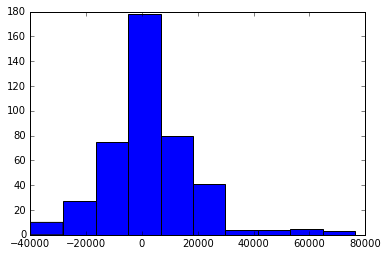

In [57]:
X_ex = Variable(X_ex)
logy_ex = Variable(np.log(y_ex))

logy_pred =  results.fwd(X_ex, logy_ex).data
y_pred = np.exp(logy_pred)
error = y_ex - y_pred.reshape(len(y_pred),)
print(error[:20])
plt.hist(error)

In [58]:
print(sum(((error > -5000)*1)*((error < 5000)*1)))
print(sum(((error > -15000)*1)*((error < 15000)*1)))
print(sum(((error > -30000)*1)*((error < 30000)*1)))

154
314
403
